In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템이 Windows일 경우
if platform.system() == 'Windows':
    plt.rc('font', family='Pretendard')
# macOS일 경우 예시:
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 1. 회원정보
features_member = [
    '남녀구분코드',
    '회원여부_이용가능_카드론', '입회경과개월수_신용', '회원여부_연체', '동의여부_한도증액안내',
    '탈회횟수_누적', '탈회횟수_발급1년이내',
    '거주시도명',
    '유효카드수_신용체크', 
    '이용카드수_신용체크', 
    '이용금액_R3M_신용체크', 
    '보유여부_해외겸용_본인', '이용여부_3M_해외겸용_본인',
    '연회비발생카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M'
]

In [3]:
selected_feature=(
    features_member)

In [5]:
print(len(selected_feature))         
print(type(selected_feature[0]))     
# 171 --> 119

16
<class 'str'>


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. 데이터 불러오기
df = pd.read_parquet("../../data/통합_train_데이터.parquet")

# 2. 피처 및 타겟 분리
X = df[selected_feature].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 라벨인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. 학습
xgb_model.fit(X_train, y_train)

# 9. 예측 및 평가
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:06:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.86      0.06      0.12       194
           1       1.00      0.10      0.19        29
           2       0.64      0.36      0.46     25518
           3       0.56      0.42      0.48     69848
           4       0.90      0.96      0.93    384411

    accuracy                           0.85    480000
   macro avg       0.79      0.38      0.44    480000
weighted avg       0.83      0.85      0.84    480000



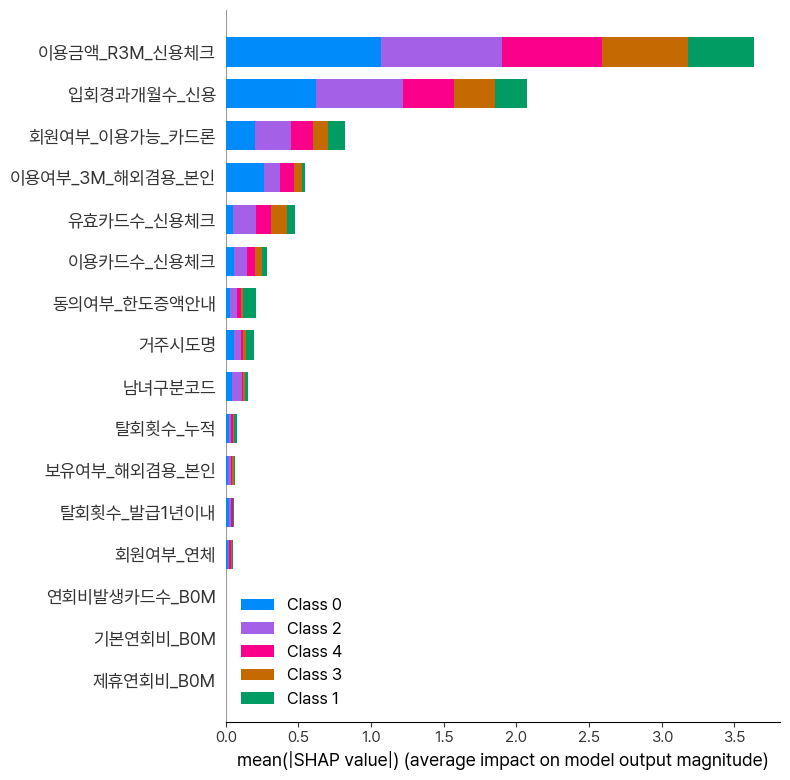

In [7]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

In [12]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

display(importance_df.head(30))

,Feature,Importance
10,이용금액_R3M_신용체크,0.522822
9,이용카드수_신용체크,0.114475
2,입회경과개월수_신용,0.089579
12,이용여부_3M_해외겸용_본인,0.075812
1,회원여부_이용가능_카드론,0.052720
8,유효카드수_신용체크,0.029971
4,동의여부_한도증액안내,0.029424
11,보유여부_해외겸용_본인,0.021502
3,회원여부_연체,0.015426
13,연회비발생카드수_B0M,0.009616


 99%|===================| 963/970 [00:45<00:00]        

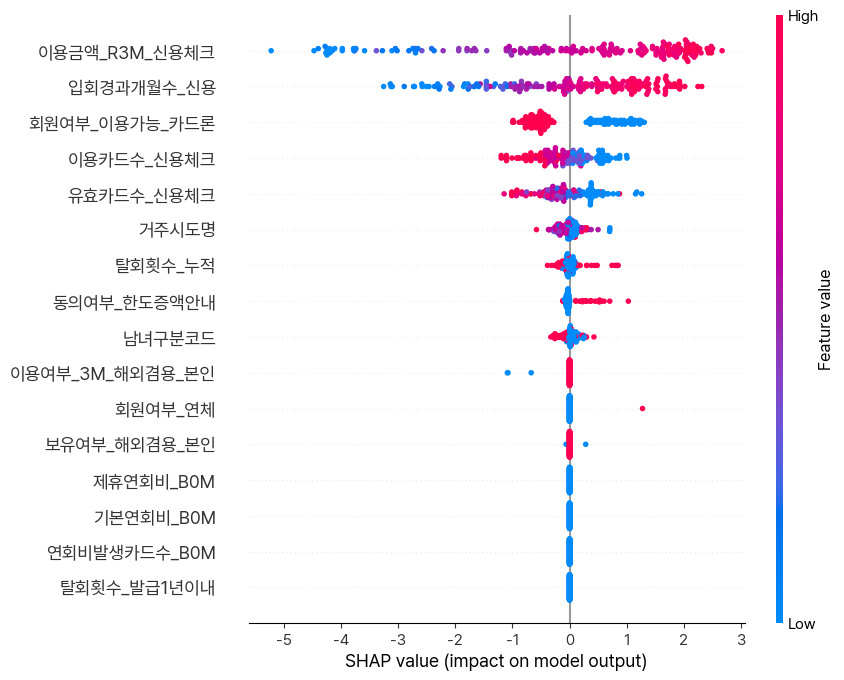

In [10]:
import shap  
import pandas as pd

# Segment 0 마스킹 + 데이터 준비
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# 샘플 수 조정
n_samples = min(len(X_val_0_all), 300)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP 해석
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

# SHAP plot (2D shap값만 전달해야 함)
shap.plots.beeswarm(shap_values_0[:, :, 0], max_display=20)

- Segment A : 이용금액_